# Мэтчинг товаров с применением библиотеки FAISS

## 1. Описание проекта

- __Задача.__
  - Разработка алгоритма, который для всех товаров из `validation.csv` найдет 5 похожих из `base.csv`.
<br><br>
- __Метрика.__
  - Необходимо максимизировать метрику `accuracy@5`, которая для каждого объекта вычисляется по формуле:
  
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$
- __Данные.__

 __Источник:__ https://disk.yandex.ru/d/BBEphK0EHSJ5Jw
  - __base.csv__ словарь с векторами товаров
  - __train.csv__ тренировочная выборка с правильным соответствием запроса и ответа из словаря
  - __validation.csv__ тестовая выборка, для которой надо найти соответствие
  - __validation_answer.csv__ образец предсказаний, необходимо для каждого запроса предоставить 10 ответов, объединенных в строку
<br>

- __Основные этапы работы.__
  - Загрузка и знакомство с данными
  - Исследовательский анализ данных:
    - Проверка на пропуски и дубликаты
    - Анализ распределения признаков и наличия выбросов
    - Анализ корреляции признаков
    - Проверка признаков на дискретность
  - Построение алгоритма с использованием FAISS 
    - Тестирование с разными наборами признаков
    - Тестирование разных вариантов масштабирования признаков
    - Тестирование с разным количеством кластеров
  - Выбор оптимального алгоритма и тестирование ее на валидационной аыборке

**Использумые библиотеки: Numpy, Sklearn, Seaborn, Matplotlib, FAISS**

## 2. Загрузка и знакомство с данными

In [1]:
# Установка FAISS
!pip install faiss-cpu

# Загрузка библиотек
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from tqdm.contrib.itertools import product
from sklearn.cluster import KMeans

# Установка стиля отображения заголовков таблиц.
styles = [
    dict(selector='caption',
         props=[('text-align', 'center'),
                ('font-size', '110%'),
                ('font-weight', 'bold'),
                ('white-space', 'pre-wrap')]),
    dict(selector="th",
         props=[('max-width', '250px')])
]
# Установка формата вывода значений
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# Чтение файлов
base = pd.read_csv('C:/Users/Sergei/Downloads/data/base.csv', index_col=0)
train = pd.read_csv('C:/Users/Sergei/Downloads/data/train.csv', index_col=0)
validation = pd.read_csv('C:/Users/Sergei/Downloads/data/validation.csv', index_col=0)
validation_answer = pd.read_csv('C:/Users/Sergei/Downloads/data/validation_answer.csv', index_col=0)

In [3]:
# Вывод основной информации на экран
for df, name in zip(
    [base, train, validation, validation_answer],
    ['Общая выборка', 'Обучающая выборка',
     'Валидационная выборка',
     'Ответы валид. выборки']
    ):
    print('\033[1m' + name + '\033[0m', '\n' + '-' * 25)
    print('\033[1mРазмер датафрейма:\033[0m')
    display(df.shape)
    display(df.head().style.set_caption(name).set_table_styles(styles))
    print('\n')
    display(df.info())
    print ('\n')

Общая выборка 
-------------------------
Размер датафрейма:


(2918139, 72)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.880890,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.061510,-32.458237,-57.420560,36.207405,182.716770,-28.071688,-5.209374,-1.732182,-91.091860,-79.466670,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.765030,-10.069234,-143.005040,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.340580,-123.626080,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.067540,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.513610,-44.659496,-80.442210,5.149714,-64.518950,-138.777630,-42.808693,38.800827,-151.762180,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.533480,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.304350,-126.768900,-68.853530,8.314717,143.081740,8.778257,15.157185,48.246360,-244.954860,-80.279420,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.155880,-7.579590,-174.369950,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.552630,-110.340170,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.010420,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.777050,58.887608,-71.595340,-251.952358,11.392853,-148.571660,-117.767525,41.100000,-157.829400,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.413830,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.822450,-22.486748,-51.666990,2.521726,140.585450,-22.039230,-7.128634,-5.184787,-111.712120,-79.029270,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.387710,-21.483440,-144.845370,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.061660,-118.758550,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.321370,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.733890,65.320880,-114.037180,-529.396956,-101.581375,-134.658220,-76.397800,46.011803,-207.144420,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.067630,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.470440,-104.537780,-82.388490,-79.986740,113.596310,-38.995880,-4.787360,8.327808,-124.855760,-79.109020,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.201980,10.613454,-134.934340,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.045300,-124.295770,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.769270,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.314320,7.912551,-62.188920,-540.321044,-89.588715,-149.326690,-70.647940,-6.358921,-147.201050,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.608030,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.342450,-38.982060,-50.228867,-26.690920,135.272900,-7.510103,8.924209,111.576950,-130.833190,-79.315850,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.385530,-44.059470,-148.131850,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.372440,-123.708980,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.540370,57.695343,-67.822630,-29.38913



<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float6

None



Обучающая выборка 
-------------------------
Размер датафрейма:


(100000, 73)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.082690,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.841370,-78.512180,-94.428940,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.715840,-27.042316,-133.212170,106.420746,-303.939233,48.730790,58.185707,24.250950,-151.224100,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.991640,-31.948470,82.314430,-115.830470,-243.309390,6.622036,-132.197660,68.712560,-38.806824,62.937435,-132.654450,89.189026,87.039780,-121.279880,-6.986934,-206.513820,29.485587,-77.029590,-132.386170,-105.427820,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.605800,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267030,-78.659430,-92.761490,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.357910,48.810093,-115.922150,87.464220,-222.286354,25.124150,91.887140,-30.636870,-136.593140,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.150900,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061080,-7.139753,75.862400,-112.045110,82.857730,54.067215,-134.005390,-26.142574,-214.632110,-457.848461,21.459618,-137.411360,-40.812233,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.346560,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.505680,-78.372925,-69.324480,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.760620,0.178065,-183.069670,99.053570,-1018.469545,-51.801120,97.766770,-10.865850,-144.423160,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.639530,-30.211614,48.527400,-122.406640,-112.713620,53.461838,-31.117260,107.841510,16.482935,77.934480,-95.618730,91.460075,63.119510,-126.939250,8.066627,-195.677670,-163.120000,-72.830000,-139.223070,-52.031662,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.517070,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789320,-78.737090,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.281800,-54.959310,-136.988540,63.880493,-1018.469545,89.228930,65.919960,-24.078644,-152.334100,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.958370,-30.800995,123.623400,-37.540867,-72.139800,71.240990,-168.115590,118.236450,-18.065195,37.255720,-137.691040,87.500770,62.437290,-131.260640,35.692660,-86.038830,-379.339090,-153.465770,-131.198290,-61.567047,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.153020,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.554630,-79.066610,-77.926460,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.693920,-20.604088,-146.591280,78.849570,-780.449185,87.560770,73.036660,16.891030,-144.657900,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.184970,-53.



<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21

None



Валидационная выборка 
-------------------------
Размер датафрейма:


(100000, 72)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.892800,-140.968570,-57.987164,-22.868887,150.895520,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.307080,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.162770,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.261570,-143.656480,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.486870,-39.484753,-124.384575,-307.949760,45.506813,-144.190950,-75.513020,52.830902,-143.439450,59.051935,69.282240,61.927513,111.592530,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.717250,-63.951330,-52.369495,-33.390945,148.619500,-22.483830,15.164185,-56.202000,-153.614380,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.383910,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.538380,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.531000,-259.636050,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.075260,-25.169033,-176.176880,-655.836897,-99.238370,-141.535220,-79.441830,29.185436,-168.605900,-82.872443,70.765600,-65.975950,97.077160,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.309540,-31.378445,-8.788761,2.285323,133.266110,-41.309080,14.305538,-18.231812,-205.533700,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.368500,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.934620,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.656990,-162.615700,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.566180,-12.822194,-154.197650,-407.199067,5.522629,-126.812970,-134.795410,37.368730,-159.662310,-119.232725,67.710440,86.002060,137.636410,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.271960,-71.406456,-65.349320,24.377070,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.309140,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.906520,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.692410,-141.523180,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.048870,-57.156870,-56.335075,-318.680065,-15.984783,-128.101330,-77.236110,44.100494,-132.530120,-106.318982,70.883960,23.577892,133.183960,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.214170,-26.393860,34.423640,50.938890,157.683180,-23.786497,-33.175415,-0.592607,-193.318540,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.268950,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.168150,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.257370,-175.656780,



<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 

None



Ответы валид. выборки 
-------------------------
Размер датафрейма:


(100000, 1)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base




<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

<font size=4>**Вывод по итогам первичного ознакомления:**

- Размер датасетов:
  - `base`: 2918139 X 72 с идентификаторами объектов в индексе;
  - `train`: 100000 X 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `validation`: 100000 X 72 с идентификаторами объектов в индексе;
  - `validation_answers`: 100000 X 1 - признак ответов с идентификаторами объектов в индексе.


## 3. Исследовательский анализ 

In [4]:
# Выделим целевой признак из датасета train
targets = train["Target"]
train.drop("Target", axis=1, inplace=True)

### 3.1. Проверка на пропуски и дубликаты

In [5]:
# Проверка на пропуски
base.isna().sum(), train.isna().sum(), validation.isna().sum()

(0     0
 1     0
 2     0
 3     0
 4     0
      ..
 67    0
 68    0
 69    0
 70    0
 71    0
 Length: 72, dtype: int64,
 0     0
 1     0
 2     0
 3     0
 4     0
      ..
 67    0
 68    0
 69    0
 70    0
 71    0
 Length: 72, dtype: int64,
 0     0
 1     0
 2     0
 3     0
 4     0
      ..
 67    0
 68    0
 69    0
 70    0
 71    0
 Length: 72, dtype: int64)

In [7]:
# Проверка на дубликаты
base.duplicated().sum(), train.duplicated().sum(), validation.duplicated().sum()

(0, 0, 0)

- **Пропуски и дубликаты не обнаружены**

### 3.2. Распределенние признаков и наличие выбросов

Для оценки распределения признаков и наличия выбросов построим гистограммы и боксплоты по всем признакам. Также посмотрим на основные статистические данные

Общая выборка 
-------------------------


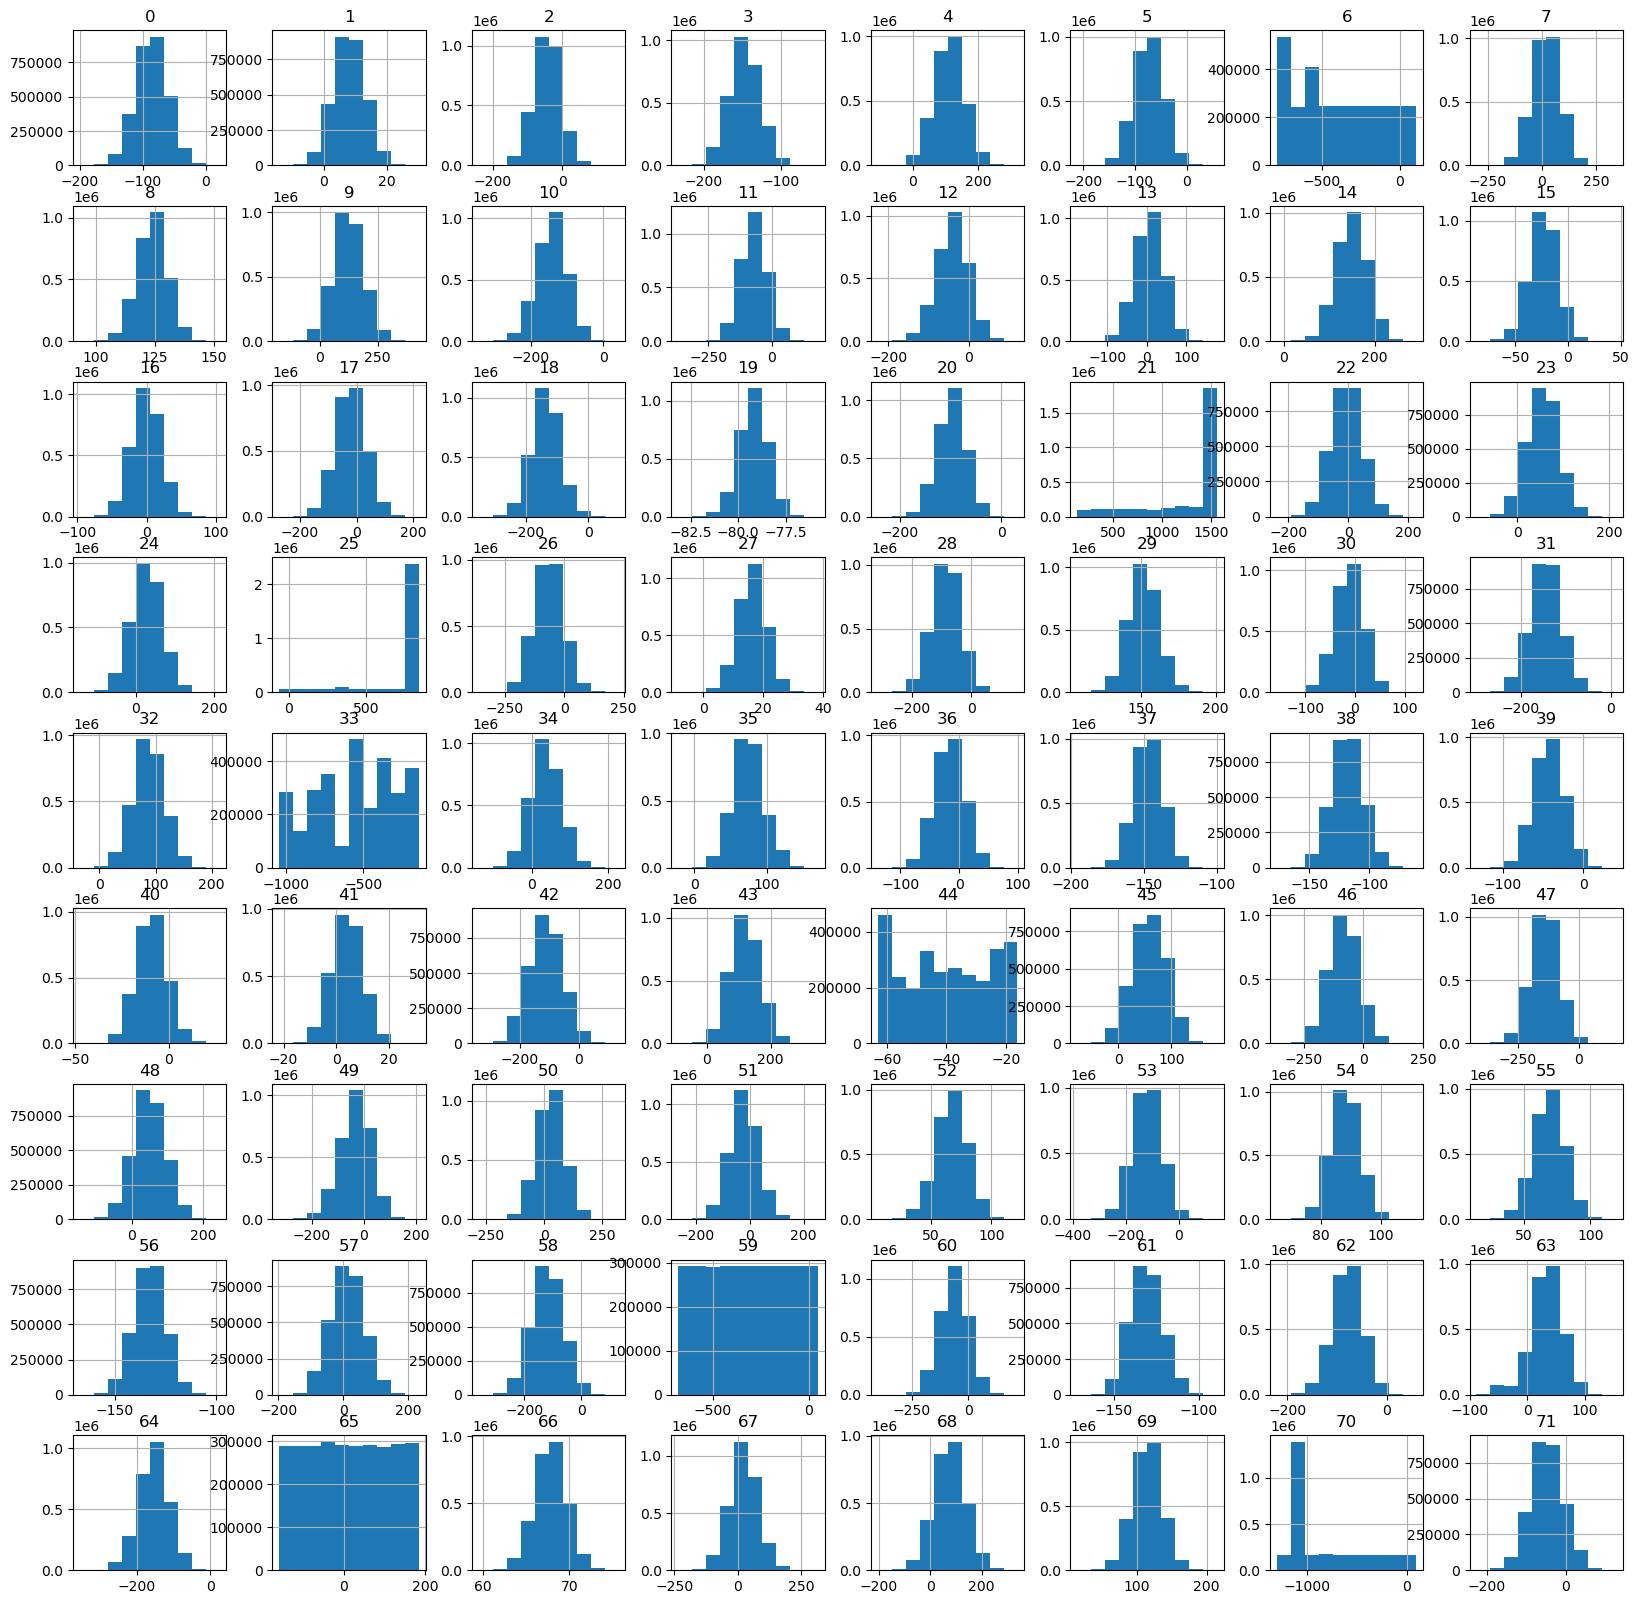

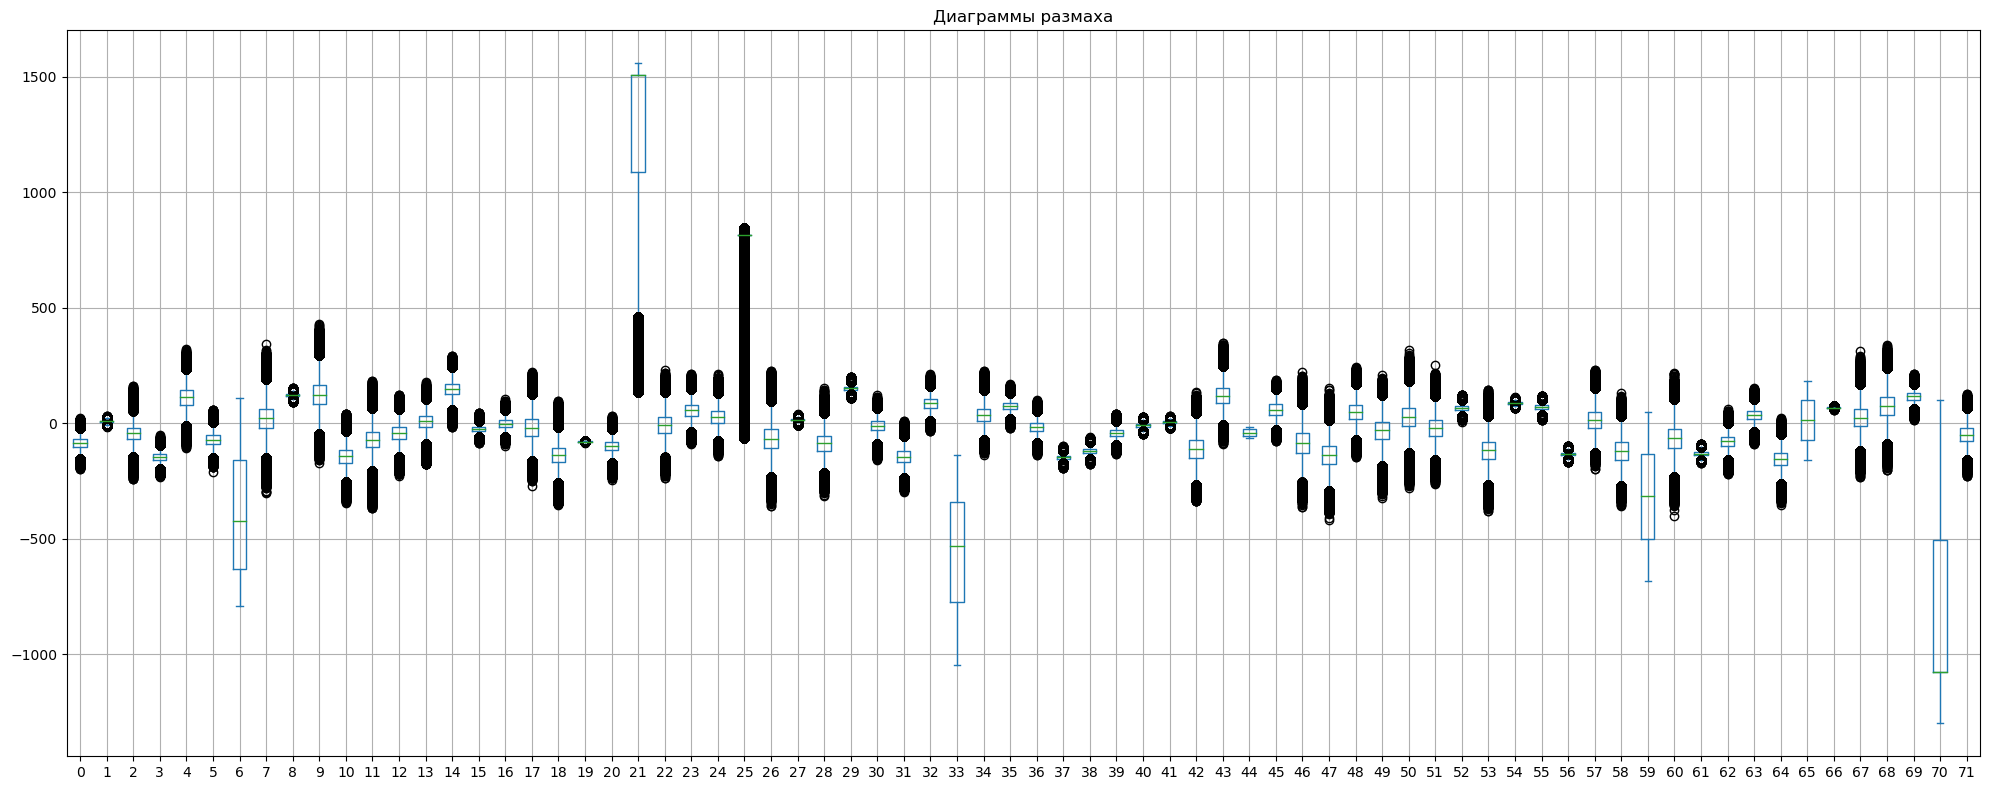

                 0            1            2            3            4  \
count 2,918,139.00 2,918,139.00 2,918,139.00 2,918,139.00 2,918,139.00   
mean        -86.23         8.08       -44.58      -146.63       111.32   
std          24.89         4.95        38.63        19.84        46.35   
min        -199.47       -13.91      -240.07      -232.67      -105.58   
25%        -103.07         4.71       -69.56      -159.91        80.51   
50%         -86.23         8.04       -43.82      -146.78       111.87   
75%         -69.26        11.47       -19.63      -133.33       142.37   
max          21.52        29.94       160.94       -51.37       319.66   

                 5            6            7            8            9  ...  \
count 2,918,139.00 2,918,139.00 2,918,139.00 2,918,139.00 2,918,139.00  ...   
mean        -71.99      -392.22        20.35       123.68       124.46  ...   
std          28.19       271.65        64.22         6.36        64.43  ...   
min        -211.0

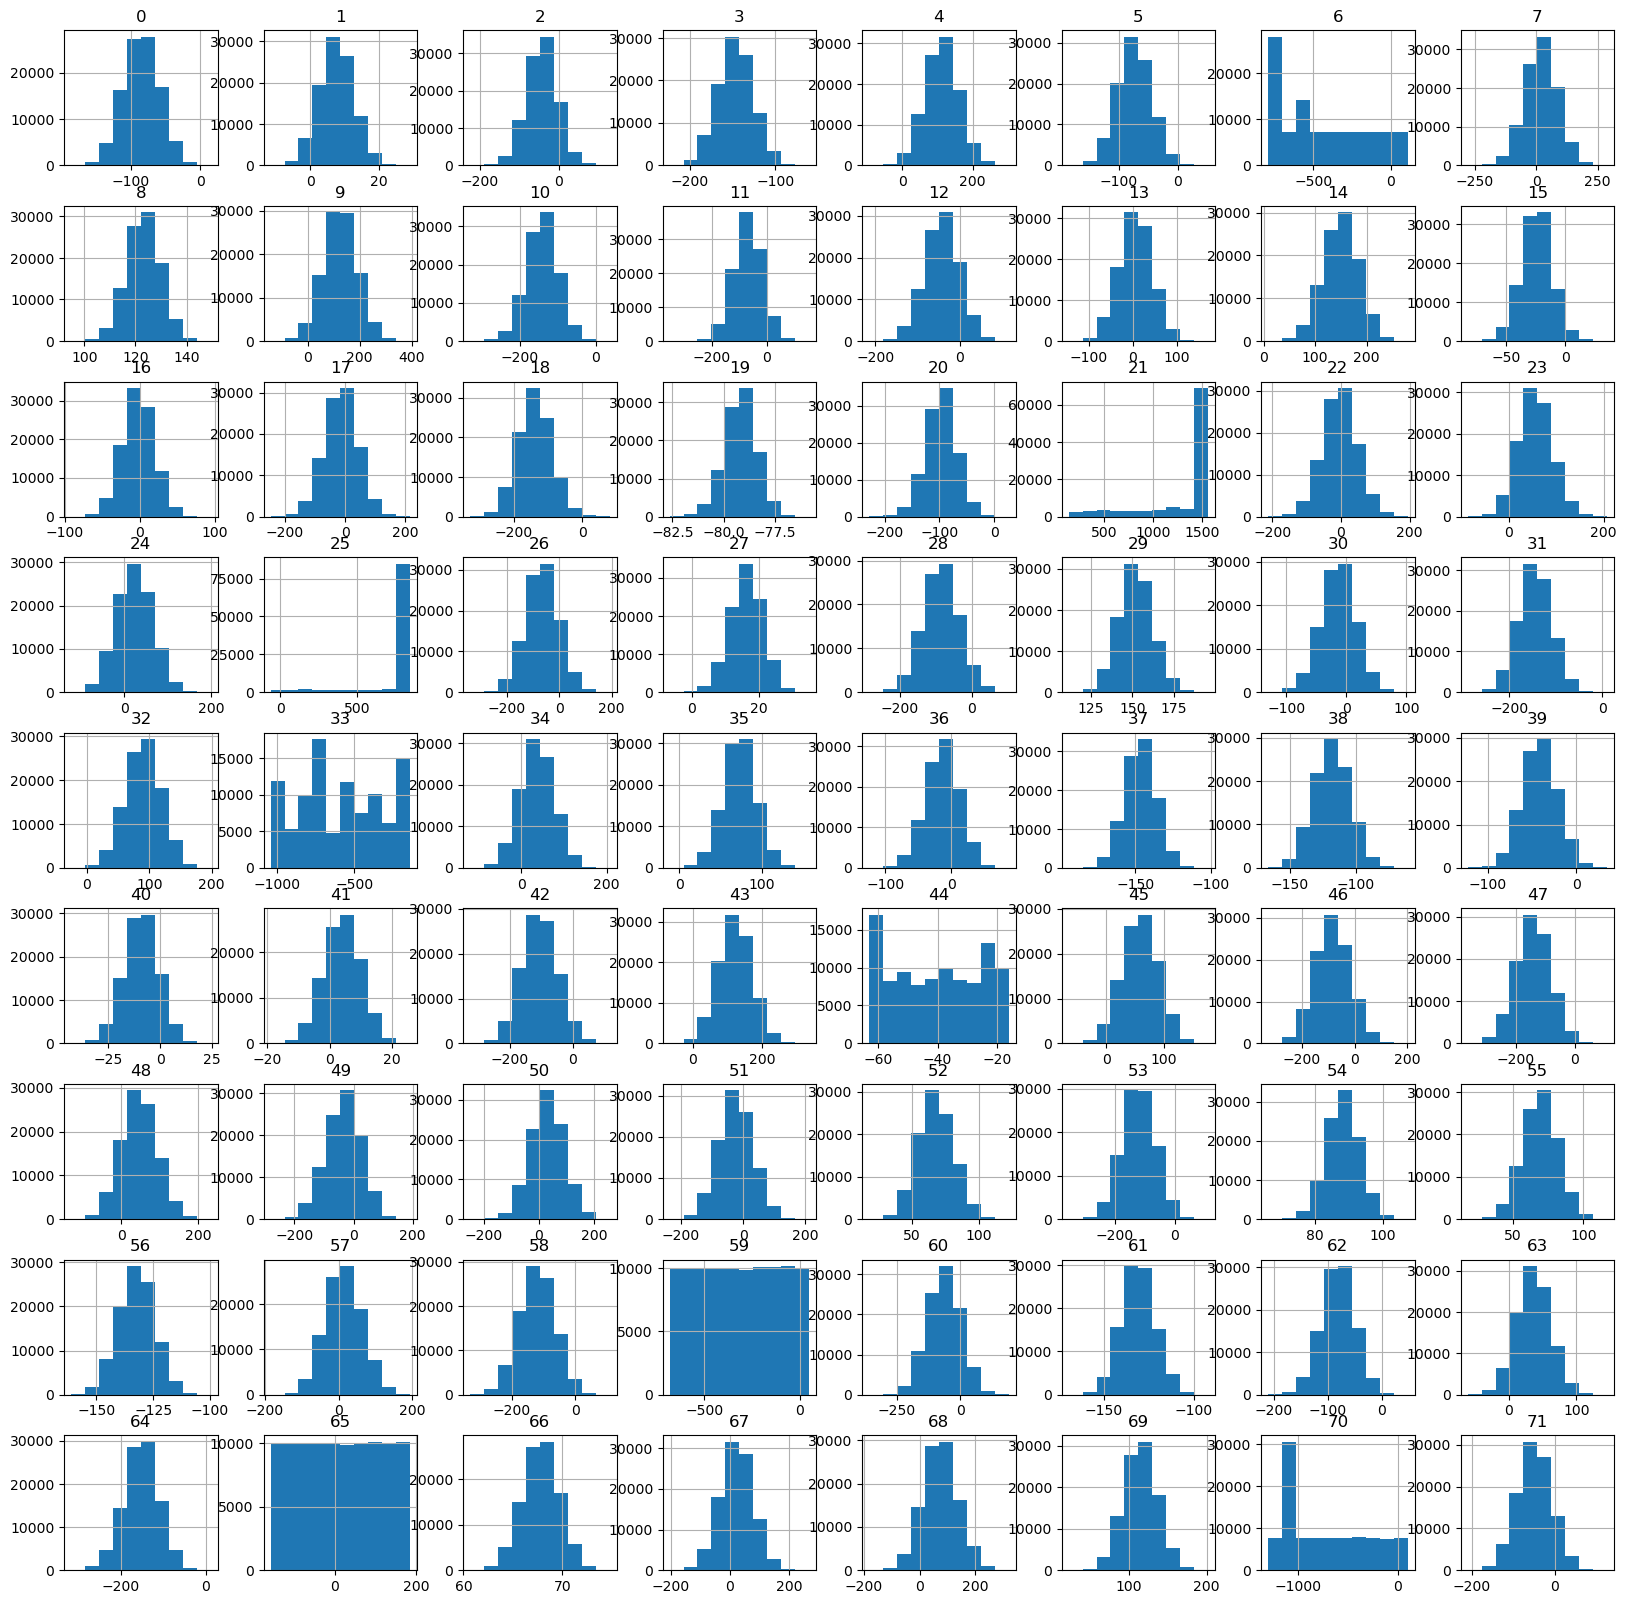

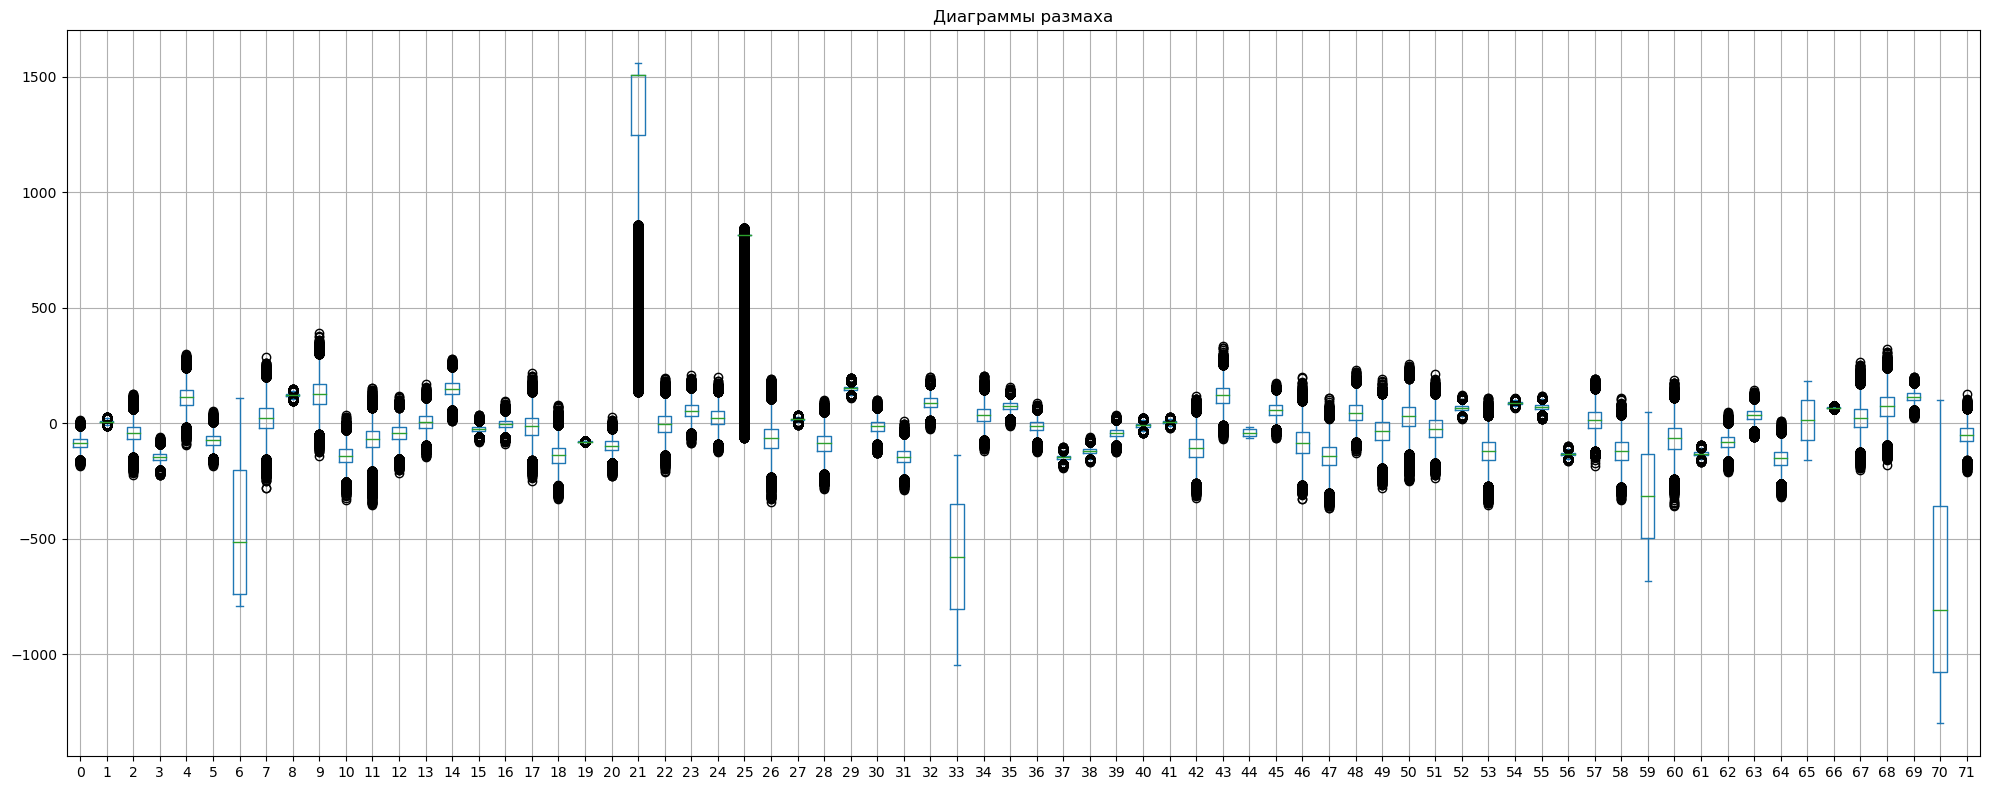

               0          1          2          3          4          5  \
count 100,000.00 100,000.00 100,000.00 100,000.00 100,000.00 100,000.00   
mean      -85.33       7.66     -43.67    -146.12     111.77     -73.18   
std        25.80       4.96      39.11      20.43      47.70      28.72   
min      -186.28     -11.56    -224.90    -223.31     -93.27    -184.96   
25%      -103.31       4.31     -69.49    -160.03      79.47     -92.83   
50%       -85.27       7.65     -42.83    -146.07     112.26     -73.36   
75%       -67.33      10.98     -17.71    -132.28     143.76     -53.70   
max        14.59      28.92     128.11     -60.75     301.36      51.85   

               6          7          8          9  ...         62         63  \
count 100,000.00 100,000.00 100,000.00 100,000.00  ... 100,000.00 100,000.00   
mean     -440.62      21.23     123.07     126.12  ...     -81.15      36.90   
std       279.02      65.99       6.49      64.91  ...      30.68      25.36   
min 

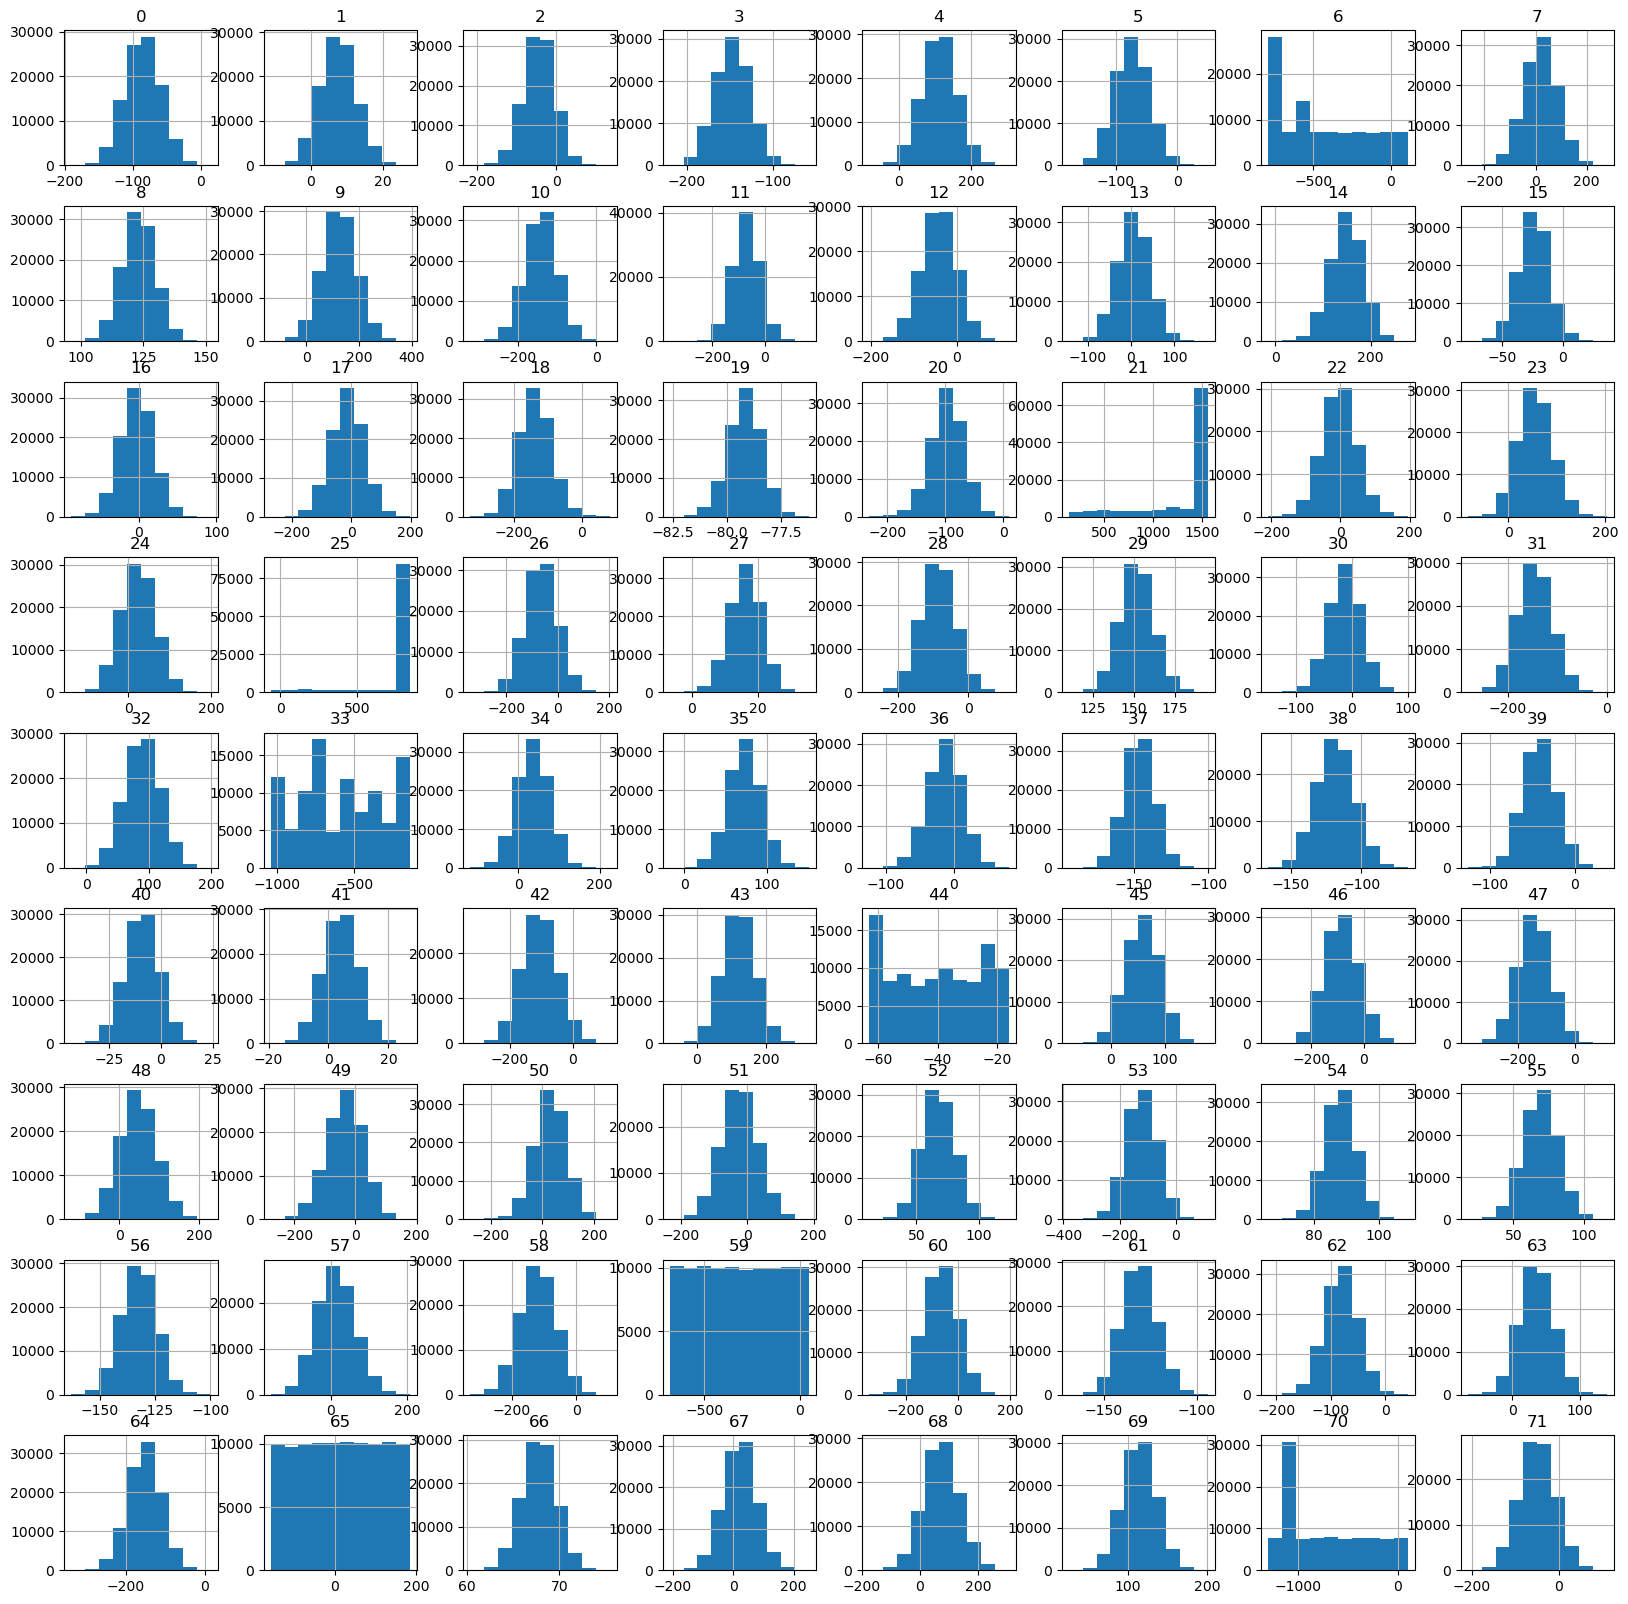

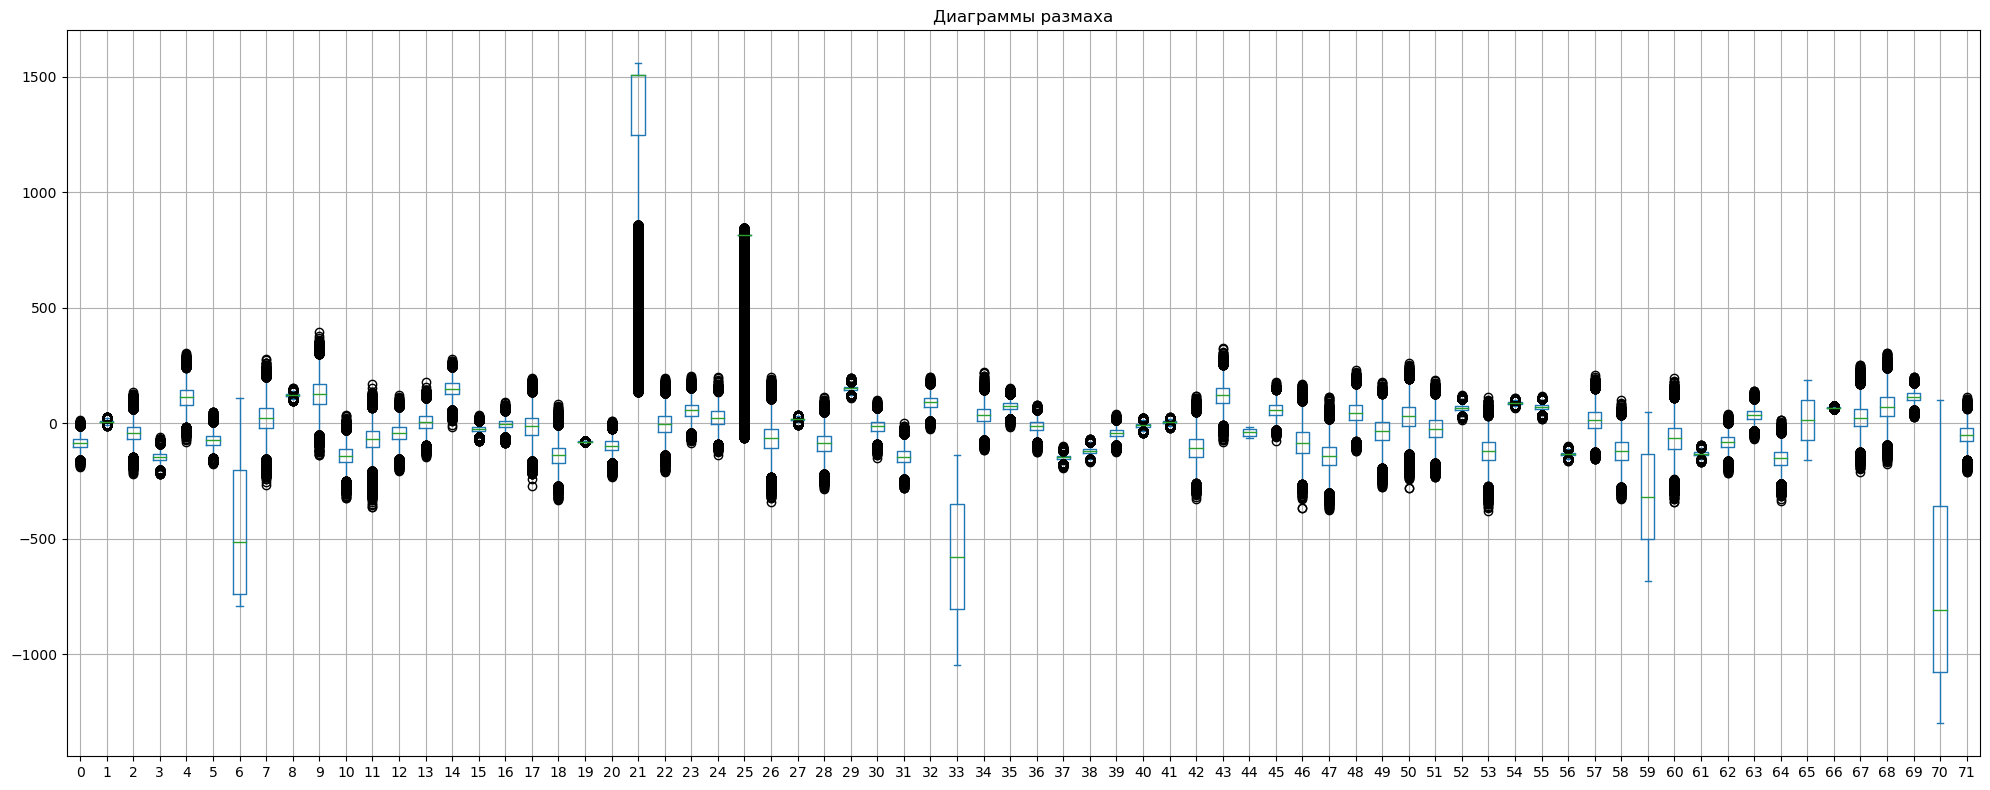

               0          1          2          3          4          5  \
count 100,000.00 100,000.00 100,000.00 100,000.00 100,000.00 100,000.00   
mean      -85.30       7.67     -43.84    -146.12     111.64     -73.27   
std        25.78       4.96      39.14      20.50      47.75      28.52   
min      -190.35     -11.11    -217.54    -220.05     -81.20    -176.71   
25%      -103.23       4.29     -69.68    -160.21      79.10     -92.79   
50%       -85.30       7.66     -43.23    -146.08     111.96     -73.58   
75%       -67.42      10.99     -17.77    -132.12     143.90     -53.86   
max        14.43      27.41     134.86     -57.38     302.07      50.26   

               6          7          8          9  ...         62         63  \
count 100,000.00 100,000.00 100,000.00 100,000.00  ... 100,000.00 100,000.00   
mean     -441.40      21.59     123.08     126.00  ...     -81.13      36.78   
std       279.24      66.48       6.50      64.98  ...      30.69      25.43   
min 

In [8]:
for df, name in zip(
    [base, train, validation],
    ['Общая выборка', 'Обучающая выборка',
     'Валидационная выборка']
    ):
    print('\033[1m' + name + '\033[0m', '\n' + '-' * 25)
    df.hist(figsize=(20,20))
    df.plot(kind='box', grid=True, figsize=[20, 8])
    plt.title('Диаграммы размаха')
    plt.tight_layout()
    plt.show()
    print(df.describe())
    print('\n' + '-' * 25);

- **В основном все признаки имеют распределение, близкое к нормальному. Исключение составляют признаки `6, 21, 25, 33, 44, 59, 65, 70`. Поскольку нам не известна природа этих признаков и даже их тип, то будет трудно предположить причину такого распределения. Можно попробовать исправить его с помощью методов масштабирования, либо просто удалить их.**
- **Некоторые признаки имеют выбросы. С ними можно поработать, например, ограничить с помощью IQR**
- **На некоторых графиках видно, что признаки имеют признаки дискретности**
- **Имеется большой разброс данных, поэтому необходимо будет применить масштабирование**

### 3.3. Проверка корреляции признаков

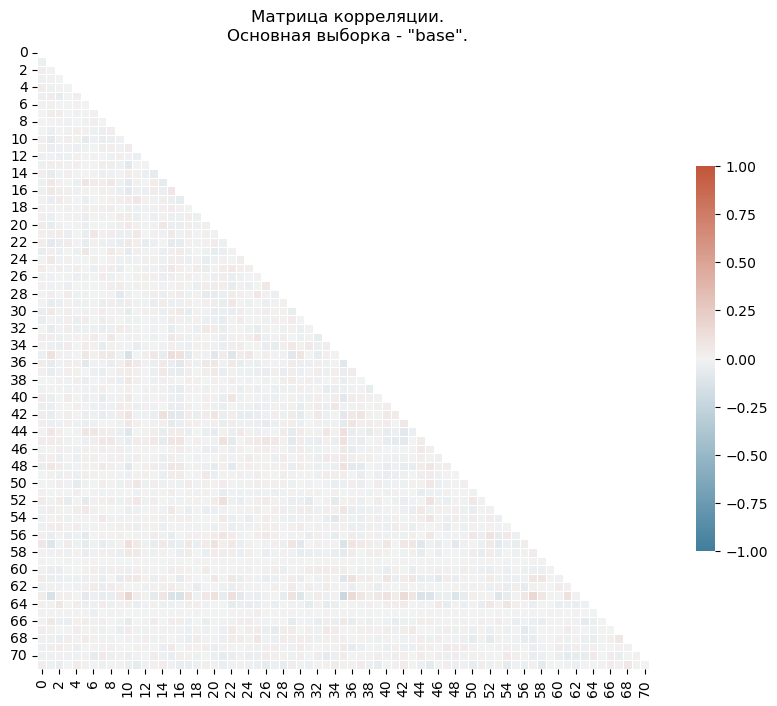

In [9]:
# Определим маску выводимых значений и цветовую схему.
mask_corr = np.triu(np.ones_like(base.corr(numeric_only=True), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Выведем матрицы корреляции.
plt.figure(figsize=(10, 10))
sns.heatmap(base.corr(numeric_only=True), mask=mask_corr, cmap=cmap,
            vmax=1, vmin=-1, square=True, linewidths=.7, cbar_kws={"shrink": .5})
plt.title('Матрица корреляции.\nОсновная выборка - "base".')
plt.show();

- **Корреляция признаков не установлена.**

### 3.4. Проверка признаков на дискретность

In [10]:
unique_ratio  = (base.nunique() / base.shape[0])
print('Признаки с менее 10% уникальных значений:')
unique_ratio[unique_ratio < .1].map('{:.2%}'.format)

Признаки с менее 10% уникальных значений:


33    0.14%
44    1.52%
dtype: object

<font size=4>**Вывод по итогам исследовательского анализа:**

- В ходе исследовательского анализа мы изменили тип данных на *float32*, это позволит быстрее производить вычесления
- Пропусков и дубликатов не обнаружено
- В основном все признаки имеют распределение, близкое к нормальному. Исключение составляют признаки `6, 21, 25, 33, 44, 59, 65, 70`. Поскольку нам не известна природа этих признаков и даже их тип, то будет трудно предположить причину такого распределения. Можно попробовать исправить его с помощью методов масштабирования, либо просто удалить их.
- Практически все признаки имеют выбросы. С ними можно поработать, например, ограничить с помощью IQR
- Имеется большой разброс данных, поэтому необходимо будет применить масштабирование
- Корреляция признаков отсутствует
- Признаки `33 и 44` дискретны, т.к. в них меньше 2% данных имеют одно значение. Скорее всего они категориальные.

## 4. Построение алгоритма с применением FAISS

In [6]:
# Сделаем функцию по созданию модели FAISS  и расчета метрики accuracy@5
# Будем использовать индекс расчета по евклидовому расстоянию IndexFlatL2
# А также инвертированный индекс с последующей проверкой IndexIVFFlat

def faiss_func (df_base, df_train, k, n):
    dims = df_base.shape[1]
    n_cells = k
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    
    # Обучаем индекс
    idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32')) 
    idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32')) 
    
    # Добаляем функцию для управления точностью 
    idx_l2.nprobe = n 
    
    # Определим базовый индекс
    base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
    
    # Осуществляем поиск   пяти соответствий
    r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)
    
    # Расчет метрики
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])

    acc_5 = (100 * acc / len(idx))
    
    return acc_5

In [7]:
# Посмотрим какая метрика получается на необработанных данных
acc_5 = faiss_func(base, train, 300, 1)
print('Метрика на базовой модели:', acc_5)

Метрика на базовой модели: 5.751


**Мы сделали функцию на базе FAISS для поиска 5-ти похожих объектов, а также для расчета метрики accuracy@5 на ее основе.
При тестировании этой модели на необработанных данных показатель метрики получился очень низкий, всего 5,751 %. Далее будем экспериментировать с разными вариантами и пытаться максимально улучшить метрику.** 

### 4.1. Тестирование с разными наборами признаков

Посмотрим как удаление какого-либо признака влияет на метрику. Для этого будем поочередно убирать один из признаков и производить расчет метрики accuracy@5

In [15]:
# Сделаем цикл, который будет поочередно удалять признаки
col = base.columns.values.tolist()

table = [] # Соберем результаты для итоговой таблицы

for c in col:
    
    # делаем копию датасетов
    base_c = base.copy()
    train_c = train.copy()
    
    # Удаляем признак
    base_c.drop([c], axis=1, inplace=True)
    train_c.drop([c], axis=1, inplace=True)
    
    # Считаем метрику на тех же параметрах, что и ранее
    acc = faiss_func(base_c, train_c, 300, 1)
    
    # Считаем разницу в метриках
    delta = acc - acc_5
    
    table.append([c, acc, delta])
    
# Выводим результат в виде таблицы
fut_table = pd.DataFrame(data=table, columns=['Признак', 'Accuracy5', 'Разница'])
fut_table.set_index('Признак')    

,Accuracy5,Разница
Признак,,
0,5.71,-0.04
1,5.75,-0.00
2,5.73,-0.02
3,5.74,-0.02
4,5.72,-0.03
...,...,...
67,5.68,-0.07
68,5.73,-0.03
69,5.73,-0.02


Из полученных результатов видно, что при удалении ряда признаков метрика возрастает. Это признаки - `15, 19, 27, 33, 34, 36, 55, 56, 59, 66`. Кроме того, у нас есть признаки с ненормальным распределением - `6, 21, 25, 33, 44, 59, 65, 70` и два дискретных признака `33 и 44`. Сделаем несколько комбинаций по удалению части из них  и оценим результаты 

**Вариант 1.** Удалим признаки, без которых метрика возрастает

**Вариант 2.** Удалим признаки с ненормальным распределением

**Вариант 3.** Удалим признаки из варианта 1 + варианта 2 

In [8]:
# Реализация варианта 1
# делаем копию датасетов
base_1 = base.copy()
train_1 = train.copy()
    
# Удаляем признаки
base_1.drop(['15','19','27','33','34','36','55','56','59','66'], axis=1, inplace=True)
train_1.drop(['15','19','27','33','34','36','55','56','59','66'], axis=1, inplace=True)

print('Метрика варианта 1:', faiss_func(base_1, train_1, 300, 1))

Метрика варианта 1: 29.121


In [9]:
# Реализация варианта 2
# делаем копию датасетов
base_2 = base.copy()
train_2 = train.copy()
    
# Удаляем признаки
base_2.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)
train_2.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)

print('Метрика варианта 2:', faiss_func(base_2, train_2, 300, 1))

Метрика варианта 2: 59.64


In [10]:
# Реализация варианта 3
# делаем копию датасетов
base_3 = base.copy()
train_3 = train.copy()
    
# Удаляем признаки
base_3.drop(['6','15','19','21','25','27','33','34','36','44','55','56','59','65','66','70'], axis=1, inplace=True)
train_3.drop(['6','15','19','21','25','27','33','34','36','44','55','56','59','65','66','70'], axis=1, inplace=True)

print('Метрика варианта 3:', faiss_func(base_3, train_3, 300, 1))

Метрика варианта 3: 59.312


**В результате экспериментов с удалением признаков, лучший результат по метрике показал вариант, когда из датасета удалены только признаки с ненормальным распределением. Остановимся на нем и дальнейшие расчеты будем произвоить с учетом этого**

### 4.2. Тестирование разных вариантов масштабирования признаков

Поскольку имеется большой разброс данных, то для лучшей работы алгоритма их нужно масштабировать. Исследуем два вида трансформеров StandardScaler, RobustScaler. Преимуществом второго является его устойчивость к выбросам, которые присутствуют в датасете.

In [11]:
# Сделаем копии датасетов
base_2_ss = base_2.copy()
train_2_ss = train_2.copy()

# Создаем скаляр
ss = StandardScaler()

# Обучаем и масштабируем данные
base_2_ss[:] = ss.fit_transform(base_2_ss)
train_2_ss[:] = ss.transform(train_2_ss)

# Считаем метрику
print('Метрика с использованием StandardScaler:', faiss_func(base_2_ss, train_2_ss, 300, 1))

Метрика с использованием StandardScaler: 62.324


In [12]:
# Сделаем копии датасетов
base_2_rs = base_2.copy()
train_2_rs = train_2.copy()


# Создаем скаляр
rs = RobustScaler()

# Обучаем и масштабируем данные
base_2_rs[:] = rs.fit_transform(base_2_rs)
train_2_rs[:] = rs.transform(train_2_rs)

# Считаем метрику
print('Метрика с использованием RobustScaler:', faiss_func(base_2_rs, train_2_rs, 300, 1))

Метрика с использованием RobustScaler: 62.343


**Вариант масштабирования с использованием RobustScaler оказался немного лучше, чем StandardScaler, поэтому дальше будем работать с ним.**

### 4.3. Тестирование с разным количеством кластеров

Мощность компьютера не позволяет достаточно быстро построить график по методу "локтя", поэтому подберем несколько значений произвольно и сравним результаты

In [21]:
# Зададим списком несколько вариантов кол-ва кластеров
kl = [50, 100, 150, 200]

# Также зададим несколько вариантов nprobe
pb = [3, 5, 7, 10]

# Сюда соберем результаты
res = []

for k in kl:
    for p in pb:
        res.append([k, p, faiss_func(base_2, train_2, k, p)])        

In [22]:
# Выведем результаты на экран
res_table = pd.DataFrame(data=res, columns=['Кол-во кластеров', 'nprobe', 'Accuracy5'])
res_table

,Кол-во кластеров,nprobe,Accuracy5
0,50,3,69.18
1,50,5,70.10
2,50,7,70.47
3,50,10,70.69
4,100,3,68.73
5,100,5,69.72
6,100,7,70.12
7,100,10,70.44
8,150,3,68.54
9,150,5,69.62


**По результатам этого теста видно, что метрика растет при уменьшении кол-ва кластеров, на которые разбивается датасет и при увеличении nprobe (кол-во кластеров, которые потом обходит модель при поиске соответсвий). Поскольку наша задача максимизировать метрику, выберем вариант с k=50 и nprobe=10, у него самая высокая метрика. Проверим ее на валидационной выборке.**

<font size=4>**Вывод по итогам тестирования:**
    
- В результате экспериментов с удалением признаков, лучший результат по метрике показал вариант, когда из датасета удалены только признаки с ненормальным распределением.
- Вариант масштабирования с использованием RobustScaler оказался немного лучше, чем StandardScaler.
- Метрика растет при уменьшении кол-ва кластеров, на которые разбивается датасет и при увеличении nprobe

## 5. Тестирование алгоритма на валидационной выборке

Итак, протестируем алгоритм, который должен найти по 5 товаров из нашего датасета, максимально похожих на каждый из товаров из валидационной выборки. Предварительно подготовим признаки валидационной выборки, согласно следующим параметрам:

- Удалим признаки с ненормальным распределением `6, 21, 25, 33, 44, 59, 65, 70`
- Масштабируем оставшиеся признаки при помощи RobustScaler

Параметры алгоритма:
- алгоритм поиска - FAISS
- количество кластеров - 50
- nprobe - 10

In [13]:
# Выделим целевой признак 
targets = validation_answer["Expected"]

In [14]:
# Сделаем копию
validation_2 = validation.copy()

# Удалим признаки
validation_2.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)

In [15]:
# Сделаем копию
validation_2_rs = validation_2.copy()

# Масштабируем
validation_2_rs[:] = rs.transform(validation_2_rs)

In [16]:
%%time

# Считaем метрику
print('Метрика accuracy@5 на валидационной выборке:', faiss_func(base_2_rs, validation_2_rs, 50, 10))
    

Метрика accuracy@5 на валидационной выборке: 70.584
CPU times: total: 1h 12min 45s
Wall time: 22min 20s


## 6. Общий вывод

В ходе работы были исследованы входящие данные, выявлено следующее:
- Пропусков и дубликатов не обнаружено
- В основном все признаки имеют распределение, близкое к нормальному. Исключение составляют признаки `6, 21, 25, 33, 44, 59, 65, 70`. Поскольку нам не известна природа этих признаков и даже их тип, то  трудно предположить причину такого распределения.
- Некоторые признаки имеют выбросы.
- Имеется большой разброс данных.
- Корреляция признаков отсутствует.
- Признаки `33 и 44` дискретны, т.к. в них меньше 2% данных имеют одно значение. Скорее всего они категориальные.

При разработке алгоритма был сделан выбор в пользу библиотеки FAISS. Была протестирована работа алгоритма с разными наборами признаков: мы выясняли при какой комбинации удаленных признаков получается добиться лучшего значения метрики. В результате было установлено, что при удалении признаков с ненормальным распределением значение `accuracy@5` выше.

Далее были протестированы два трансформатора данных `StandardScaler` и  `RobustScaler`. Преимуществом второго является его устойчивость к выбросам, которые присутствуют в датасете. В итоге, он и показал немного лучший результат.

При подборе оптимального количества кластеров и значения nprobe (кол-во кластеров, которые обходит модель при поиске соответсвий), мы остановились на варианте 50 кластеров и nprobe = 10. При уменьшении первого значения и увеличении второго, метрика будет расти, но значительно увеличится время поиска.

**Таким образом, задача, поставленная в начале проекта - выполнена. Разработан алгоритм, который для всех товаров из `validation.csv` находит 5 похожих из `base.csv`. Значение целевой метрики `accuracy@5` _70.584_ на валидационной выборке было достигнуто при следующих параметрах:**
  - **алгоритм FAISS;**
  - **кол-во кластеров 50;**
  - **индекс `IndexIVFFlat`;**
  - **масштабирование данных с помощью `RobustScaler`;**
  - **с удалением признаков, распределённых ненормально.**
  
  

<font size=4>**Рекомендации/Возможные направления улучшения.**
    
Для возможного улучшения метрики можно сделать следующее:
 - применить алгоритм ANNOY
 - попробовать более развернутый анализ кластеров, определение оптимального количества с K-meens
 - в FAISS протестировать другие индексы, например `IVFHNSWFLAT`